# Time Series with ARIMA
In this notebook I will deal with time series using ARIMA with this challenge on Kaggle `https://www.kaggle.com/datasets/rakannimer/air-passengers/code` 

In [9]:
# General settings and import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

## Load dataset and make some visualization

In [10]:
workdir = print(os.path.abspath(os.curdir))

/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/Progetto/Spadari-AirPassengers


Make sure to check in which directory you are running, and which is the path of the dataset 

In [11]:
# Set the path of the csv file
path = "AirPassengers.csv"

df = pd.read_csv(path)
df["Month"] = pd.to_datetime(df["Month"])
df = df.set_index("Month")

#Showing the shape of the dataset
df.shape

(144, 1)

Here we plot the data and we can visualize them graphically

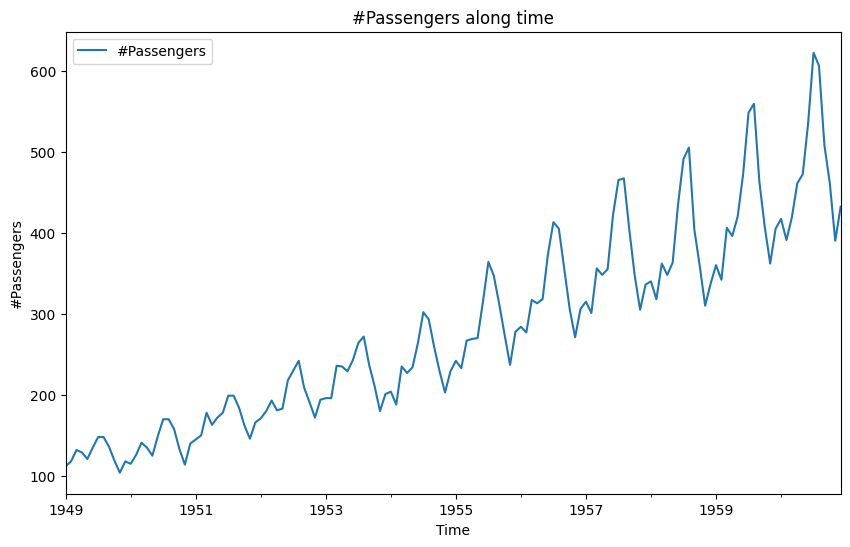

In [12]:
ax = df.plot(title="#Passengers along time", xlabel="Time", ylabel="#Passengers")
plt.show()

Calculating the rolling mean and standard deviation for a window of 12 months

In [13]:
rolmean= df.rolling(window=12).mean().dropna()
rolstd= df.rolling(window=12).std().dropna()
print("Number of NaN row removed:",len(df) - len(rolmean))
print("Number of NaN row removed:",len(df) - len(rolstd))

display(rolmean, rolstd)

Number of NaN row removed: 11
Number of NaN row removed: 11


,#Passengers
Month,
1949-12-01,126.666667
1950-01-01,126.916667
1950-02-01,127.583333
1950-03-01,128.333333
1950-04-01,128.833333
...,...
1960-08-01,463.333333
1960-09-01,467.083333
1960-10-01,471.583333


,#Passengers
Month,
1949-12-01,13.720147
1950-01-01,13.453342
1950-02-01,13.166475
1950-03-01,13.686977
1950-04-01,13.822467
...,...
1960-08-01,83.630500
1960-09-01,84.617276
1960-10-01,82.541954


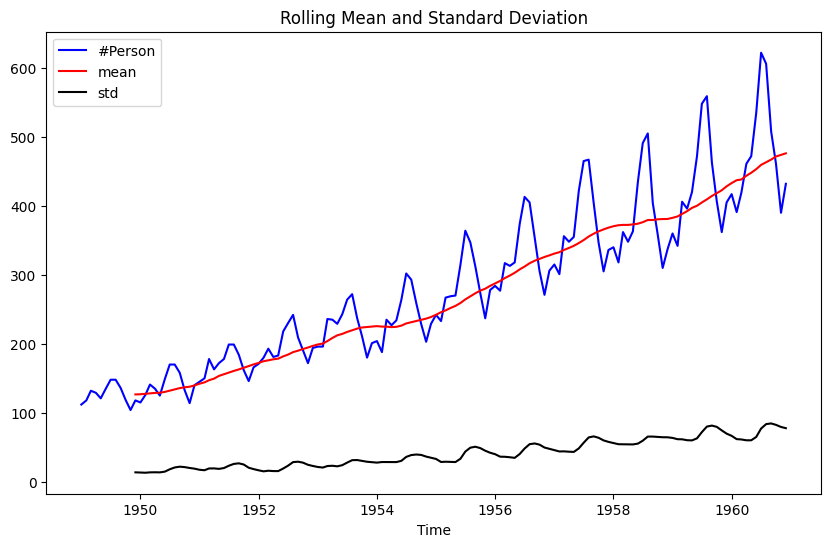

In [14]:
plt.plot(df, color="blue", label="#Person")
plt.plot(rolmean, color="red", label="mean")
plt.plot(rolstd, color="black", label="std")
plt.legend()
plt.title("Rolling Mean and Standard Deviation")
plt.xlabel("Time")
plt.show()


### Stationary

To apply ARIMA to a dataset, we must be sure the ts is `stationary`.  

To define if it is stationary or not, the time serie should has costant mean and standard deviation through the time, and as we can see in the graph, neither the mean and the standard dev is costant.

So now we will try with the test to demonstrate that it is not stationary.

In [15]:
print("Result of Dickey Fuller Test:\n")
dftest= adfuller(df["#Passengers"], autolag='AIC')
# display(dftest)

dfoutput= pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
# display(dfoutput)

for key, value in dftest[4].items():
    dfoutput[f'Critical Value ({key})']= value

print(dfoutput)

Result of Dickey Fuller Test:

Test Statistic                  0.815369
p-value                         0.991880
#Lags Used                     13.000000
Number of Observation Used    130.000000
Critical Value (1%)            -3.481682
Critical Value (5%)            -2.884042
Critical Value (10%)           -2.578770
dtype: float64


For a Time series to be stationary, its ADCF test should have:

- p-value to be low (according to the null hypothesis)
- The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics.

From the above ADCF test result, we see that p-value(at max can be 1.0) is very large. Also critical values are not close to the Test Statistics.  
Hence, we can safely say that our Time Series at the moment **is not stationary**

In [16]:
def test_stationary(df , window = 12):
    mov_avg= df.rolling(window=window).mean()
    mov_std = df.rolling(window=window).std()

    plt.plot(df, color="blue", label="#Person")
    plt.plot(mov_avg, color="red", label="mov_avg")
    plt.plot(mov_std, color="black", label="mov_std")
    plt.title("Moving average and moving std along the time")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

    print("Results of Dickey Fuller Test:\n")
    dftest= adfuller(df)
    dfoutput= pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observation Used"])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value

    print(dfoutput)
    print(f"\np-value={dfoutput['p-value']}")
    print(f"Difference with critical value:\n{[f"{np.abs(dfoutput['Test Statistic'] - cv):0.3f}" for cv in dfoutput[4:]]}")

## Data Trasformation to become `Stationary`
To achieve stationarity we will compute log trasformations.  
The aim is to make deviation more stable.

### Log Scale Trasformation

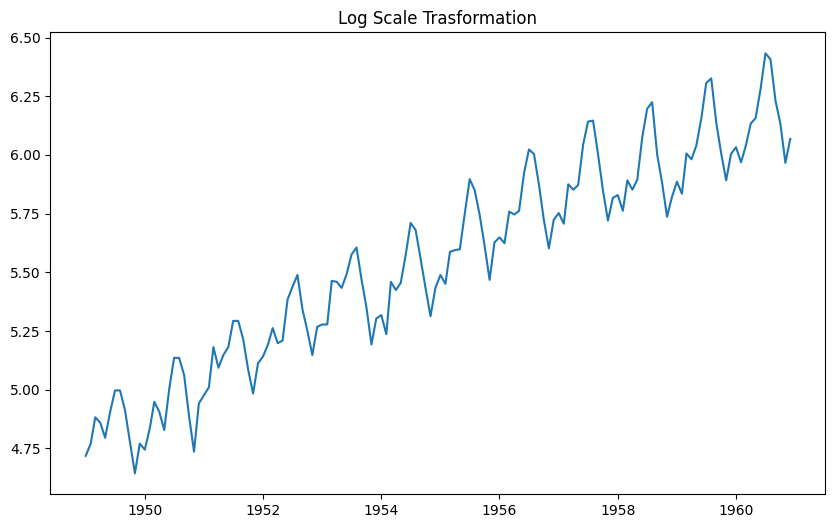

In [17]:
#Log Scale Trasformation

df_logScale= np.log(df)
plt.plot(df_logScale)
plt.title("Log Scale Trasformation")
plt.show()

As you can see the y range is no more 100-600, but 4.75-6.50 and that's help to have a better results in the ADF test, because the differences among data values is smaller.

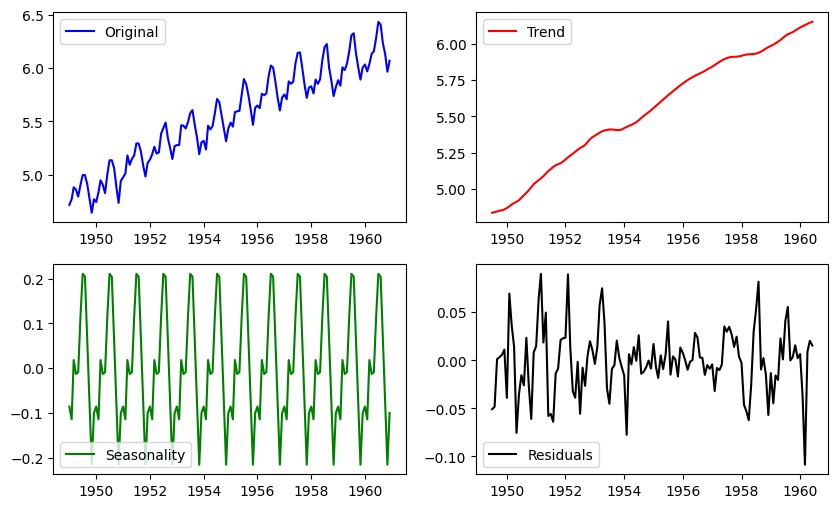

In [18]:
decomposition = seasonal_decompose(df_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(2,2,1)
plt.plot(df_logScale, color="blue", label='Original')
plt.legend(loc='best')

plt.subplot(2,2,2)
plt.plot(trend, color="red", label='Trend')
plt.legend(loc='best')

plt.subplot(2,2,3)
plt.plot(seasonal, color="green", label='Seasonality')
plt.legend(loc='best')

plt.subplot(2,2,4)
plt.plot(residual, color="black", label='Residuals')
plt.legend(loc='best')
plt.show()

Here it is possible to observe the different components of the ts (trend, seasonality and residuals)

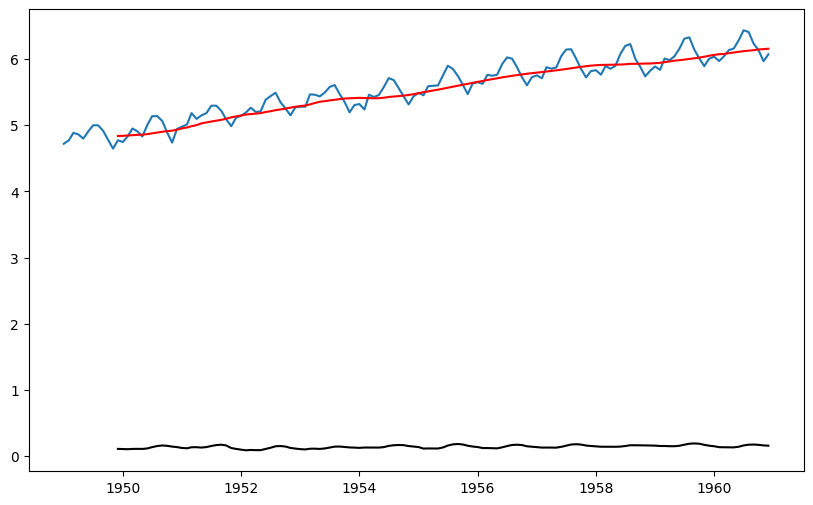

In [21]:
mov_avg = df_logScale.rolling(window=12).mean().dropna()
mov_std = df_logScale.rolling(window=12).std().dropna()

plt.plot(df_logScale)
plt.plot(mov_avg, color="red")
# plt.show()

plt.plot(mov_std, color="black")
# plt.ylim(0,6.5)
plt.show()

To remove the trend component from the time series we will compute the difference between the log series and its moving average.

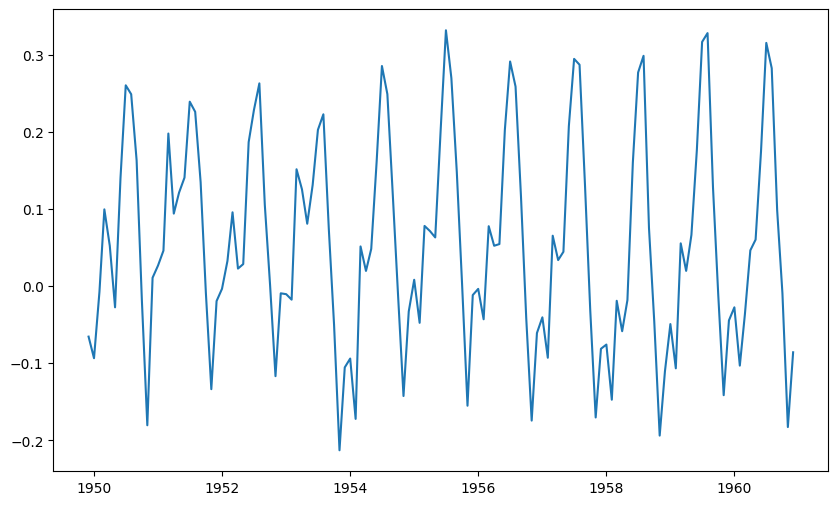

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


In [25]:
df_trans_movavg = df_logScale - mov_avg
df_trans_movavg = df_trans_movavg.dropna()
plt.plot(df_trans_movavg)
plt.show()

df_trans_movavg.head(10)

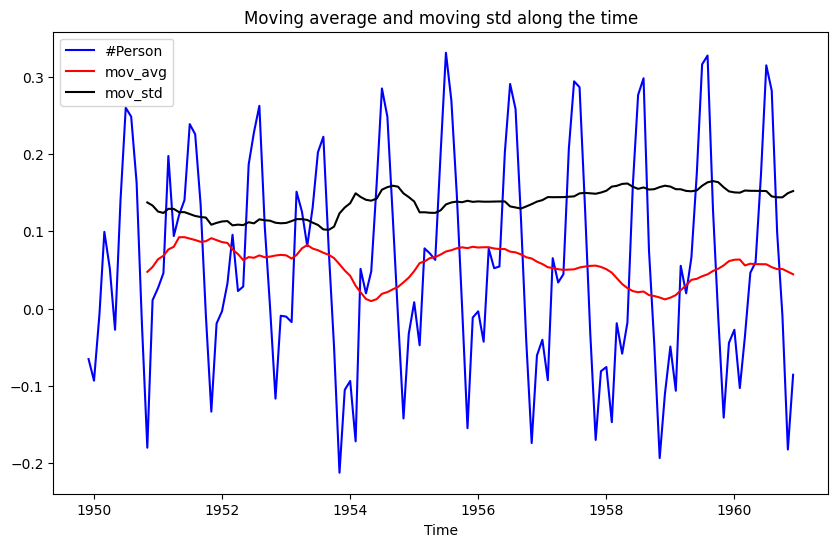

Results of Dickey Fuller Test:

Test Statistic                 -3.162908
p-value                         0.022235
#Lags Used                     13.000000
Number of Observation Used    119.000000
Critical Value (1%)            -3.486535
Critical Value (5%)            -2.886151
Critical Value (10%)           -2.579896
dtype: float64

p-value=0.022234630001242303
Difference with critical value:
['0.324', '0.277', '0.583']


In [312]:
test_stationary(df_trans_movavg)

Now we can see that the `p-value` is pretty close to 0 and the `critical values` to the test statistic, so now we can say that the series is "Stationary".  
But the job isn't done, we will try also with other tpe of trasformation.

### Exponential Decay Trasformation
Now we want to try with an other trasformation to see if it could be more accurate. That would be the subtraction of the exponential decay to remove the trend component. 

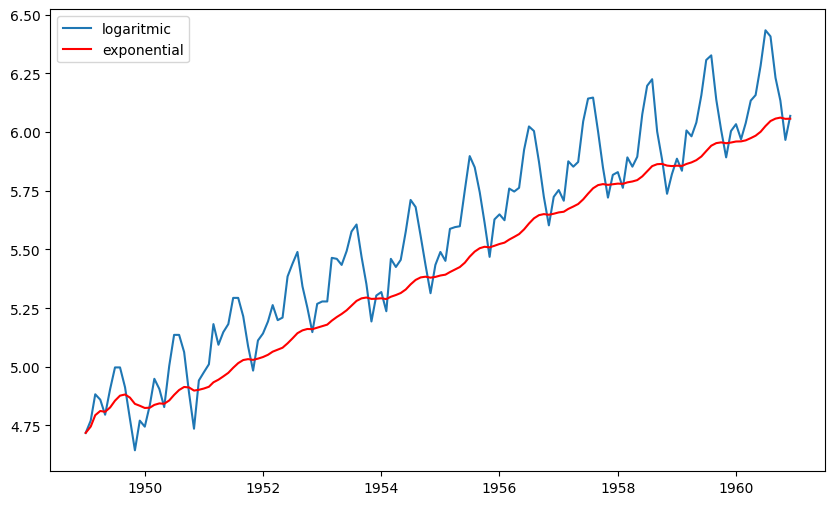

In [313]:
df_exp = df_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()

plt.plot(df_logScale, label="logaritmic")
plt.plot(df_exp, color="red", label="exponential")
plt.legend()
plt.show()

Now we compute the subtracion.

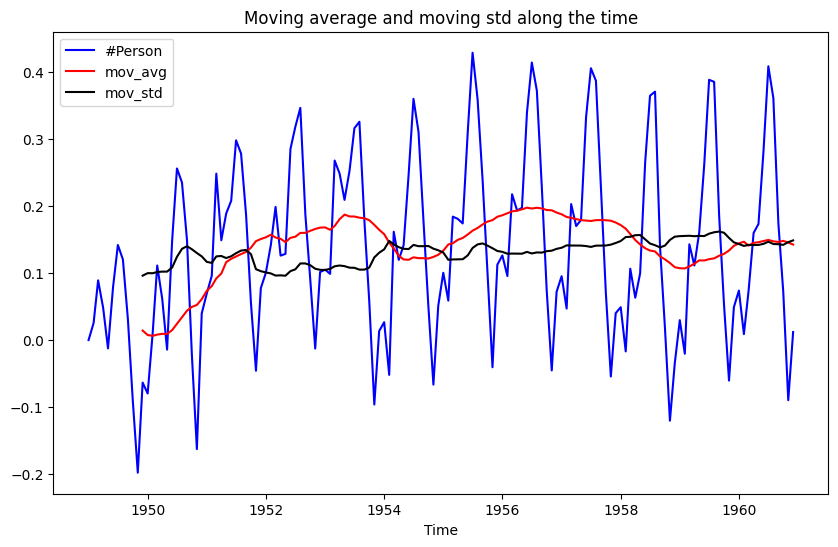

Results of Dickey Fuller Test:

Test Statistic                 -3.601262
p-value                         0.005737
#Lags Used                     13.000000
Number of Observation Used    130.000000
Critical Value (1%)            -3.481682
Critical Value (5%)            -2.884042
Critical Value (10%)           -2.578770
dtype: float64

p-value=0.005736938801511787
Difference with critical value:
['0.120', '0.717', '1.022']


In [314]:
df_trans_exp = df_logScale - df_exp
test_stationary(df_trans_exp)

As I can see, the `p-value` is much smaller (closer to 0), but as for the `critical points` it seems that are less closer.  
But as I'm following this [`notebook`](https://www.kaggle.com/code/freespirit08/time-series-for-beginners-with-arima/notebook) it says that the seocnd is better.

But then we want to use an other trasformation, that will be the `Time Shift Trasformation`

### Time Shift Trasformation

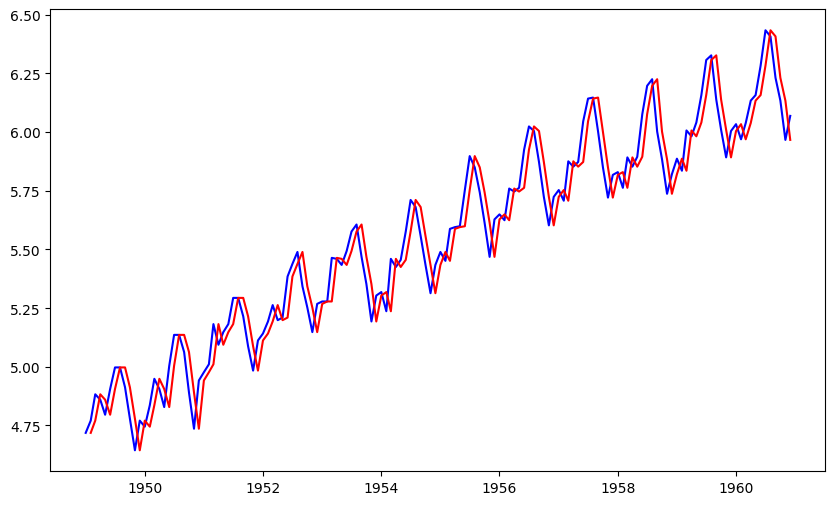

In [315]:
plt.plot(df_logScale, color="blue", label="logaritmic")
plt.plot(df_logScale.shift(), color="red", label="time shifted")

We can see that they have the same trend component.

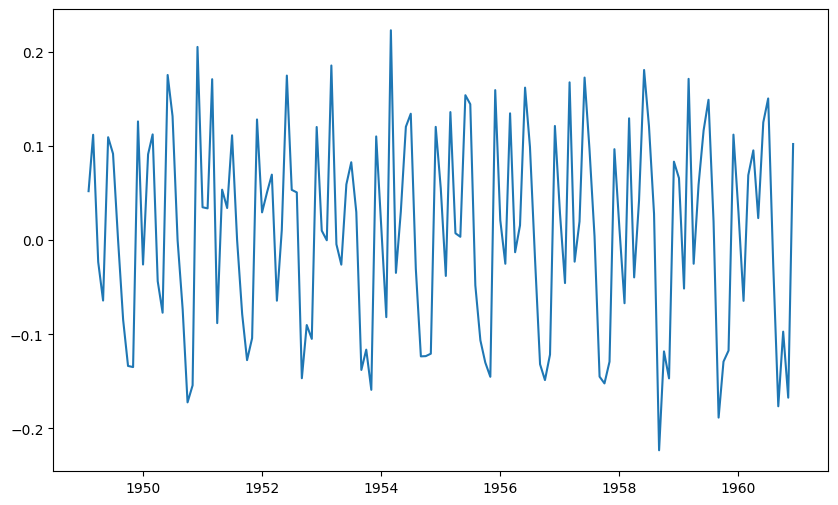

In [316]:
df_trans_ts = df_logScale - df_logScale.shift()
plt.plot(df_trans_ts)

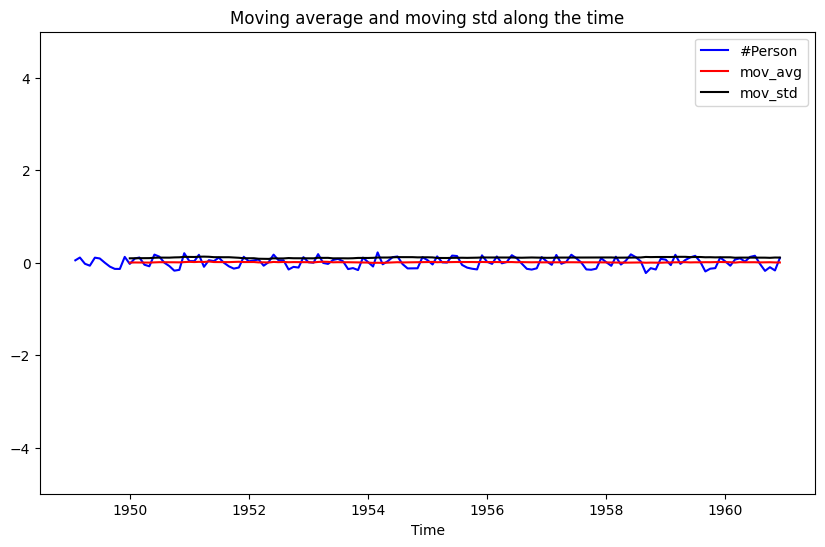

Results of Dickey Fuller Test:

Test Statistic                 -2.717131
p-value                         0.071121
#Lags Used                     14.000000
Number of Observation Used    128.000000
Critical Value (1%)            -3.482501
Critical Value (5%)            -2.884398
Critical Value (10%)           -2.578960
dtype: float64

p-value=0.07112054815085629
Difference with critical value:
['0.765', '0.167', '0.138']


In [317]:
df_trans_ts = df_trans_ts.dropna()
plt.ylim(-5,5)
test_stationary(df_trans_ts)

We can say that that this is the best result so far.  
We can observe that the `p-value` is a little higher than the previous one, but it is still very low. Otherwise we can see that for the critical values they are closer than the previous one

So we can have a stationary series by applying a log-scale trasformation to reduce de standard deviation trend, and a time shift differentation to remove the trend component.
So we can use the ARIMA model using the logscale trasformation with integration = 1, so d=1.  
Now we need to plot `ACF` and `PACF` to complete with `q` and `p`.

## Training using ARIMA model 

We will see two different approach. In the first one we will select p and q manually, looking at ACF and PACF, then we will try also vith some models as AUTOArima or other type, that can find this parameters by themselves.

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1958-08-01,6.224558
1958-09-01,6.001415
1958-10-01,5.883322


,#Passengers
Month,
1959-01-01,5.886104
1959-02-01,5.834811
1959-03-01,6.006353
1959-04-01,5.981414
1959-05-01,6.040255
1959-06-01,6.156979
1959-07-01,6.306275
1959-08-01,6.326149
1959-09-01,6.137727


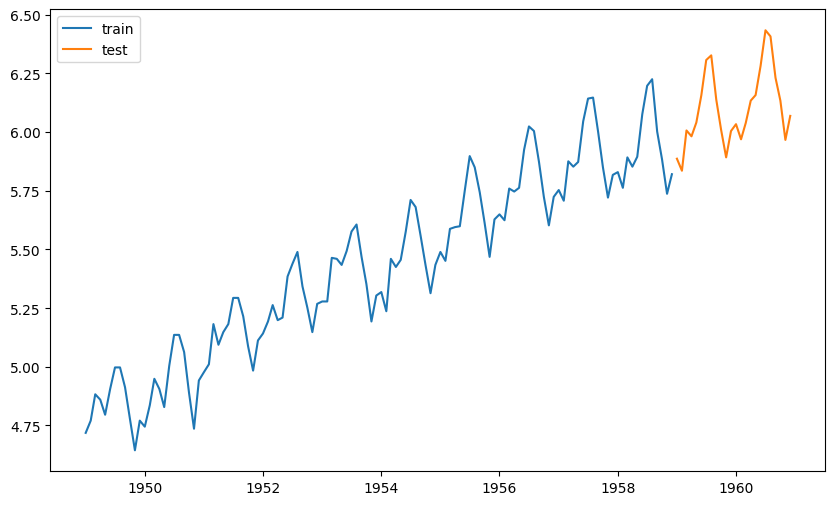

In [ ]:
# PREPARING TRAIN AND TEST SET
#This code is because I didn't want to split train and test in the middle of a year.
years = len(df_logScale.index.year.unique())  #to evaluate how many years in the dataset
train_percent=0.9   #to set the train percent desired
train_size= int(years*train_percent) *12    #to extract the train percentage years
train, test = df_logScale[0:train_size], df_logScale[train_size:]

display(train, test)
plt.plot(train, label="train")
plt.plot(test, label="test")
plt.legend()   
plt.show()

### Manually

#### What are `ACF` and `PACF` ????

**ACF** stands for Auto Correlation Function, and shows how much a data measured in a certain *t*, can be influenced by the previous ones.
- Why a data can be influenced by the previous ones?
    If we make an example, we can think that maybe if you spent a great amount of money now, it will influences the money spent in the next days, weeks, months and years.
    So a big amount of money spent today could influence money sent in the future, and with autocorrelation function we are interest in seeing how much the money spent today, could be influenced by the mone spent 1d before, 2d before, 3d before,......

But ACF can measure the correlation in two way: directly and indirectly. 
- directly: this is the correlation on how much a data from the past influence on today.
- indirectly: here there is the information about how much this data influences the next one, that influence the next one, till we reach the current instant.

We can say that a data measured in a certain *t*, can have a direct effect on the current data, or an indirect link that means all the links from that *t* to all the consecutive *t* among the current one.

Here we can explain *what is **PACF***:
PACF is Partial Auto Correlation Function, and its aim is to provide only the "direct link", not all the indirect ones.

What this two indicator says to us?
- ACF: it contains many factor in it. A certain istant could be so correlated with an other, because of all of those consecutive links.
- PACF: It allows us to see only how much a past data is correlated with the current ones. It deletes all that indirect effect.



#### Plotting `ACF` and `PACF` to get `q` and `p` (Manually)
At first, we need to discover the parameters p and q, so we will proceed with the plot of AFC and PACF.

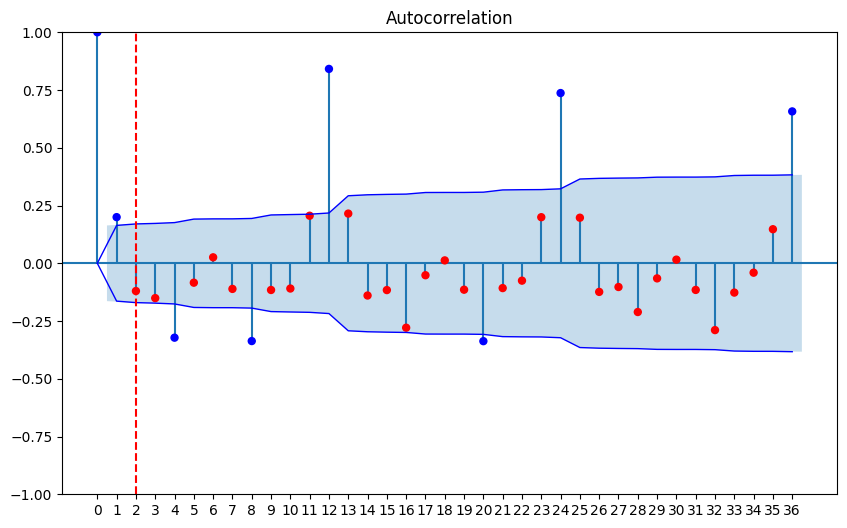

,#lag,-conf,ACF,conf
0,0.0,-0.000000,1.000000,0.000000
1,1.0,-0.163903,0.199751,0.163903
2,2.0,-0.170318,-0.120104,0.170318


First non-significant ACF lag: q = 1




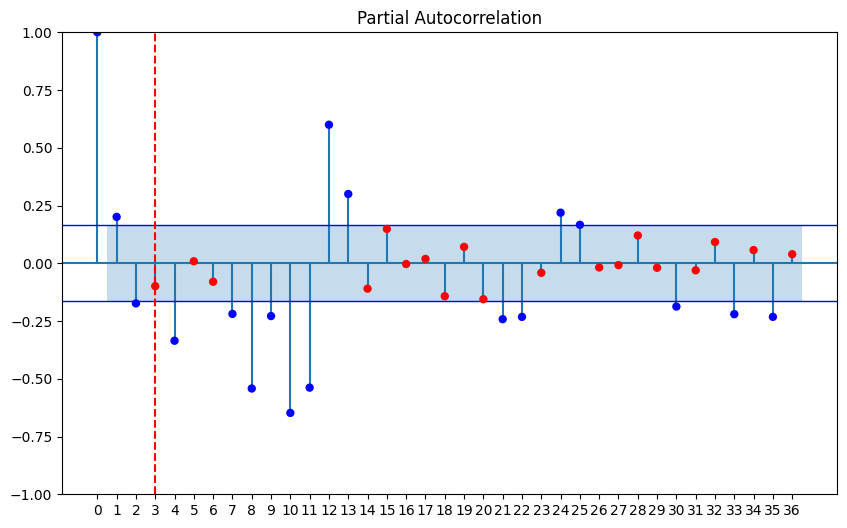

,#lag,-conf,PACF,conf
0,0.0,-0.163903,1.000000,0.163903
1,1.0,-0.163903,0.200815,0.163903
2,2.0,-0.163903,-0.173682,0.163903
3,3.0,-0.163903,-0.099012,0.163903


First non-significant PACF lag: p = 2


In [319]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Parameters
nlags = 36
N = len(df_trans_ts)
z = 1.96  # 95% confidence level


# ==========================================================
# ACF
# ==========================================================
acf_vals = acf(df_trans_ts, nlags=nlags)

# Compute Bartlett confidence intervals (centered at 0)
acf_conf = np.zeros(nlags+1)
for k in range(1, nlags+1):
    acf_conf[k] = z * np.sqrt((1 + 2 * np.sum(acf_vals[1:k]**2)) / N)
    # Each lag’s variance increases with the cumulative sum of squared previous ACFs

# Determine colors: red if inside confidence band, blue if outside
# - red if within confidence band (non-significant)
# - blue if outside confidence band (significant autocorrelation)
acf_colors = np.where((acf_vals > acf_conf) | (acf_vals < -acf_conf), 'blue', 'red')

# Build a table with ACF values and confidence limits for reference
acf_df = pd.DataFrame(columns=["#lag","-conf", "ACF", "conf"])
for i, v in enumerate(acf_vals):
    acf_df.loc[len(acf_df)]= [i, -acf_conf[i],v,acf_conf[i]]
    # Find the first lag where ACF falls within the confidence band
    if -acf_conf[i] <= v <= acf_conf[i]:
        q = i-1
        break

# Plot ACF with colored points and vertical line at first non-significant lag
plot_acf(df_trans_ts, lags=nlags, marker=None)  # marker=None hides default blue markers from plot_acf
# Manually plot scatter points with our custom colors and size
plt.scatter(range(nlags + 1), acf_vals, c=acf_colors, zorder=2,  # zorder keeps points above lines
            s=(rcParams['lines.markersize'] / 1.2) ** 2)         # s = marker size
plt.plot(acf_conf, c="b", lw=1)
plt.plot(-acf_conf, c="b", lw=1)
plt.xticks(range(nlags+1)) # show tick labels for each lag from 0 to nlags
plt.axvline(q+1, c="r", label="q", linestyle="--")    # Vertical line for first non-significant lag
plt.show()

display(acf_df)
print(f"First non-significant ACF lag: q = {q}\n\n")


# ==========================================================
# PACF
# ==========================================================
pacf_vals = pacf(df_trans_ts, nlags=nlags, method="ols")

# PACF confidence band (constant across lags, unlike ACF Bartlett bounds)
pacf_conf = z / np.sqrt(N)

# Determine colors: red if inside confidence band, blue if outside
pacf_colors = np.where((pacf_vals > pacf_conf) | (pacf_vals < -pacf_conf), 'blue', 'red')

# Find the first lag where PACF falls within the confidence band
pacf_df = pd.DataFrame(columns=["#lag", "-conf", "PACF", "conf"])
for i, v in enumerate(pacf_vals):
    pacf_df.loc[len(pacf_df)]= [i, -pacf_conf,v,pacf_conf]
    if -pacf_conf <= v <= pacf_conf:
        p = i-1
        break

# Plot PACF with colored points and vertical line at first non-significant lag
plot_pacf(df_trans_ts, lags=nlags, marker=None, method='ols')
plt.xticks(range(nlags+1))  # show tick labels for each lag
plt.axhline(pacf_conf, c="b", lw=1)
plt.axhline(-pacf_conf, c="b", lw=1)
plt.axvline(p+1, c="r", label="p", linestyle="--")
plt.scatter(range(nlags+1), pacf_vals, c=pacf_colors, zorder=2, s=(rcParams['lines.markersize']/1.2) ** 2)
plt.show()
20
display(pacf_df)
print(f"First non-significant PACF lag: p = {p}")



### Models build
Even if we are using ARIMA, we will try first only AR and MA to see the difference and to make some evaluation.

#### AR Model

/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


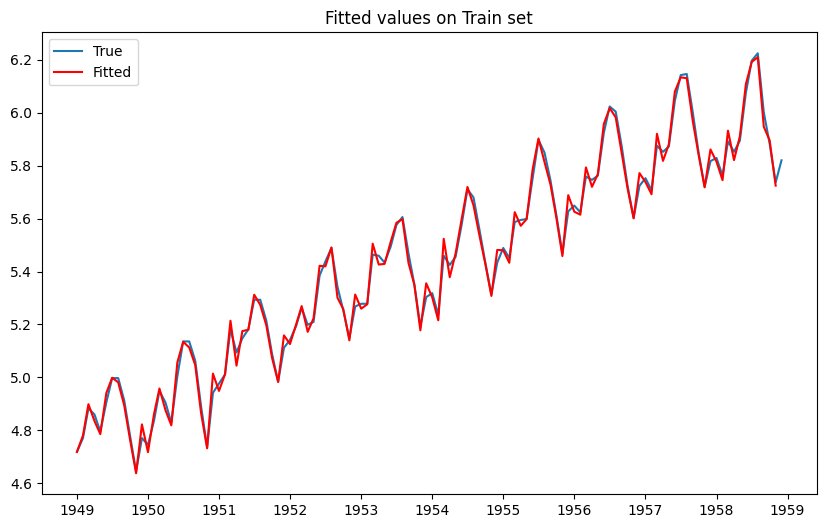

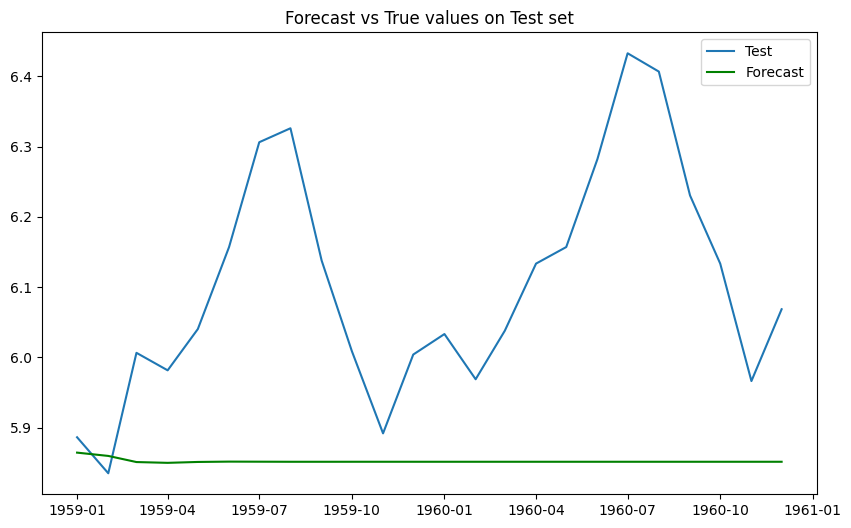

RSS: 2.11


In [320]:
ar = ARIMA(train, order=(p,1,0))
results_AR = ar.fit()

fitted_values_AR = results_AR.fittedvalues.shift(-1)

# Forecast for the test set
forecast_AR = results_AR.forecast(steps=len(test))
forecast_AR.index = test.index  # align index for plotting and RSS

plt.title("Fitted values on Train set")
plt.plot(train, label="True")
plt.plot(fitted_values_AR, c="r", label="Fitted")
plt.legend()
plt.show()

plt.title("Forecast vs True values on Test set")
plt.plot(test, label="Test")
plt.plot(forecast_AR, c="g", label="Forecast")
plt.legend()
plt.show()

RSS_ar = ((forecast_AR - test["#Passengers"])**2).sum()
print(f"RSS: {RSS_ar:.2f}")

#### MA Model

/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


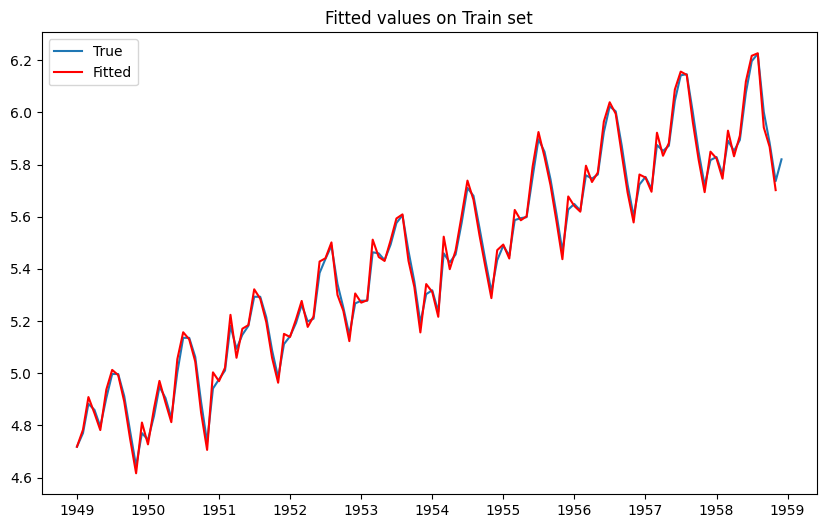

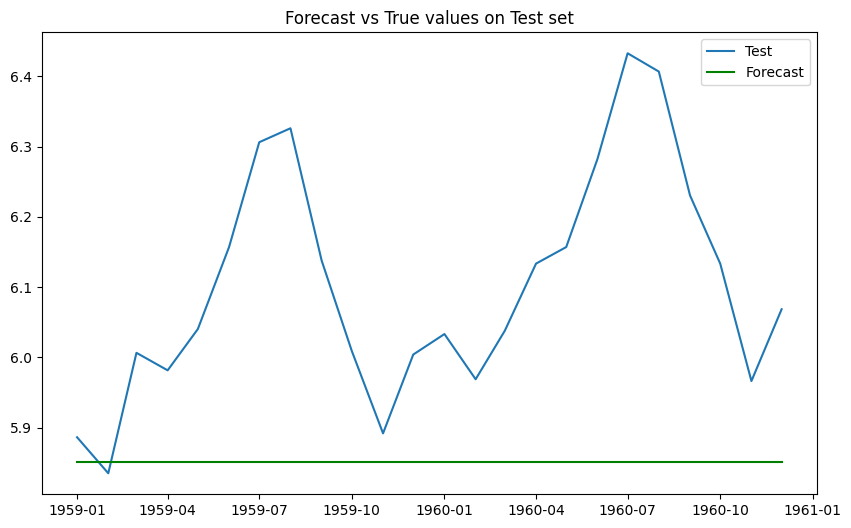

RSS: 2.11


In [321]:
ma = ARIMA(train, order=(0,1,q))
results_MA= ma.fit()

fitted_values_MA = results_MA.fittedvalues.shift(-1)

# Forecast for the test set
forecast_MA  = results_MA.forecast(steps=len(test))
forecast_MA.index = test.index  # align index for plotting and RSS

plt.title("Fitted values on Train set")
plt.plot(train, label="True")
plt.plot(fitted_values_MA, c="r", label="Fitted")
plt.legend()
plt.show()

plt.title("Forecast vs True values on Test set")
plt.plot(test, label="Test")
plt.plot(forecast_MA, c="g", label="Forecast")
plt.legend()
plt.show()

RSS_ma = ((forecast_MA - test["#Passengers"])**2).sum()
print(f"RSS: {RSS_ma:.2f}")

#### ARIMA
After using AR and MA now we will use ARIMA.

/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


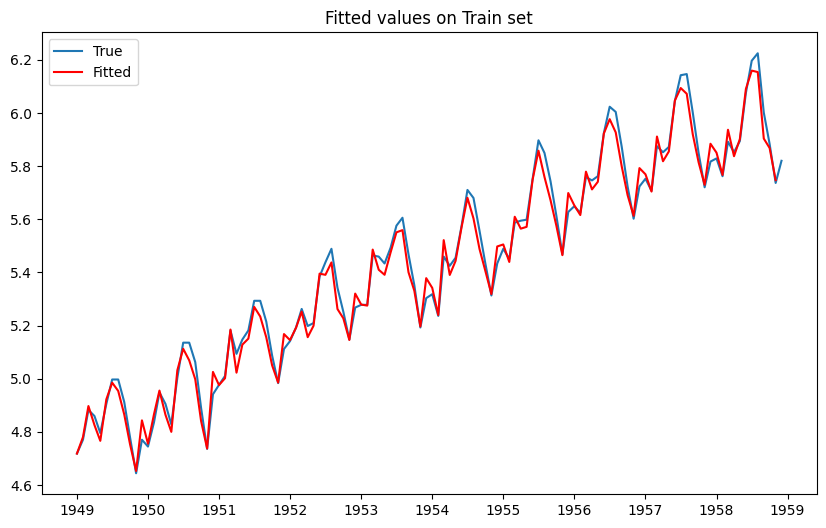

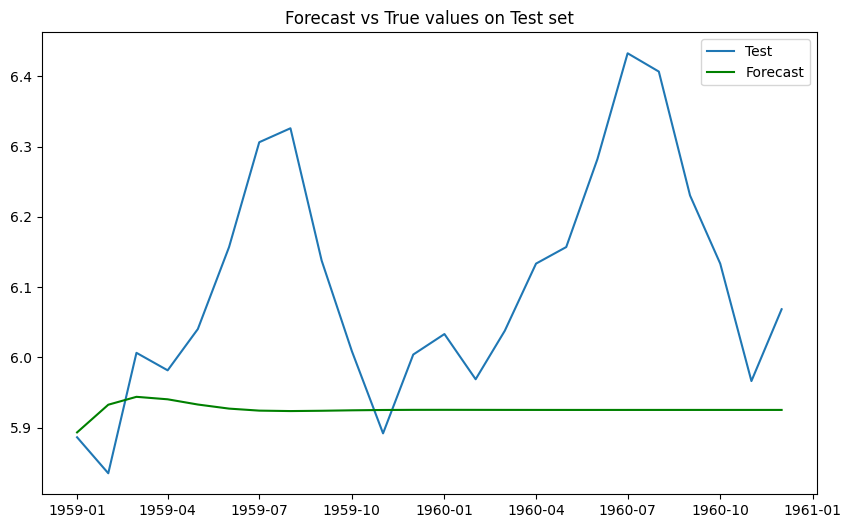

RSS: 1.35


In [322]:
arima = ARIMA(train, order=(p,1,q))
results_ARIMA= arima.fit()

fitted_values_ARIMA = results_ARIMA.fittedvalues.shift(-1)

# Forecast for the test set
forecast_ARIMA  = results_ARIMA.forecast(steps=len(test))
forecast_ARIMA.index = test.index  # align index for plotting and RSS

plt.title("Fitted values on Train set")
plt.plot(train, label="True")
plt.plot(fitted_values_ARIMA, c="r", label="Fitted")
plt.legend()
plt.show()

plt.title("Forecast vs True values on Test set")
plt.plot(test, label="Test")
plt.plot(forecast_ARIMA, c="g", label="Forecast")
plt.legend()
plt.show()

RSS_arima = ((forecast_ARIMA - test["#Passengers"])**2).sum()
print(f"RSS: {RSS_arima:.2f}")

##### SARIMA

There is still another pattern that ARima can't capture, and it is **seasonality**.
So the last model that I want to try is **SARIMA**.


SARIMA(2, 1, 1)x(0, 0, 1, 12)


/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


AIC: -281.76 | BIC: -267.87

SARIMA(2, 1, 1)x(1, 0, 1, 12)


/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWar

AIC: -397.99 | BIC: -381.32

SARIMA(0, 1, 0)x(0, 0, 1, 12)
AIC: -274.95 | BIC: -269.39

SARIMA(0, 1, 0)x(1, 0, 1, 12)


/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


AIC: -392.18 | BIC: -383.85


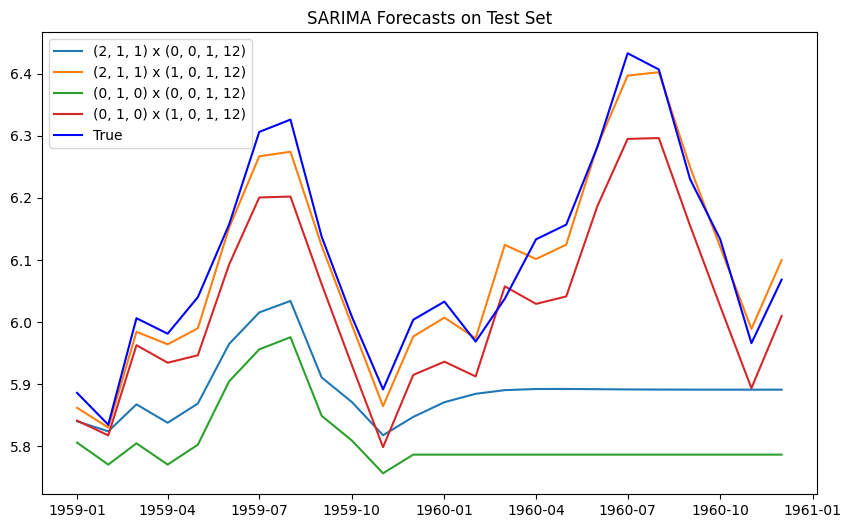

,Model,RSS
1,"(2, 1, 1) x (1, 0, 1, 12)",0.023574
3,"(0, 1, 0) x (1, 0, 1, 12)",0.177485
0,"(2, 1, 1) x (0, 0, 1, 12)",1.482903
2,"(0, 1, 0) x (0, 0, 1, 12)",2.540283


Best model: (2, 1, 1) x (1, 0, 1, 12)


In [323]:
# SARIMA: test di diversi ordini per catturare stagionalità e autocorrelazioni multiple

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Proviamo diversi ordini per AR, MA e stagionalità
orders_to_try = [
    # ((p,1,q), (0,0,1,6)),
    ((p,1,q), (0,0,1,12)),
    # ((p,1,q), (1,0,1,6)),
    ((p,1,q), (1,0,1,12)),
    # ((0,1,0), (0,0,1,6)),
    ((0,1,0), (0,0,1,12)),
    # ((0,1,0), (1,0,1,6)),
    ((0,1,0), (1,0,1,12)),

]

results_models = []

for order, seasonal_order in orders_to_try:
    print(f"\nSARIMA{order}x{seasonal_order}")
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order, suppress_warnings="true")
    results = model.fit()
    print(f"AIC: {results.aic:.2f} | BIC: {results.bic:.2f}")
    preds = results.forecast(steps=len(test))

    plt.plot(preds, label=f"{model.order} x {model.seasonal_order}")

    RSS_model = ((preds - test["#Passengers"])**2).sum()
    results_models.append([f"{model.order} x {model.seasonal_order}", RSS_model])
    # results.plot_diagnostics(figsize=(10,6))
    # plt.show()

plt.plot(test, label="True", c="b")
plt.title("SARIMA Forecasts on Test Set")
plt.legend()
plt.show()

display(pd.DataFrame(results_models, columns=["Model", "RSS"]).sort_values(by="RSS"))
print(f"Best model: {pd.DataFrame(results_models, columns=["Model", "RSS"]).sort_values(by="RSS").iloc[0, 0]}")

Best parameters are p=2, q=1 and P=1, Q=1, s=12

In [334]:
p=2
q=1
P=1
Q=1
s=12

/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


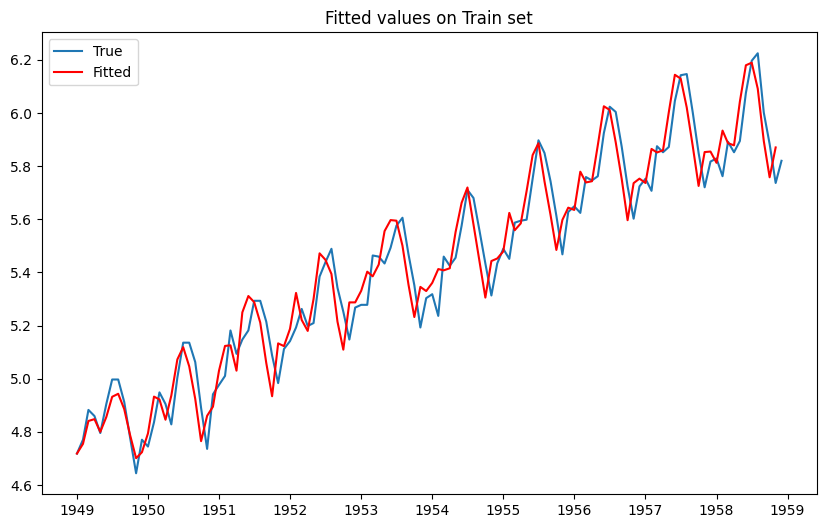

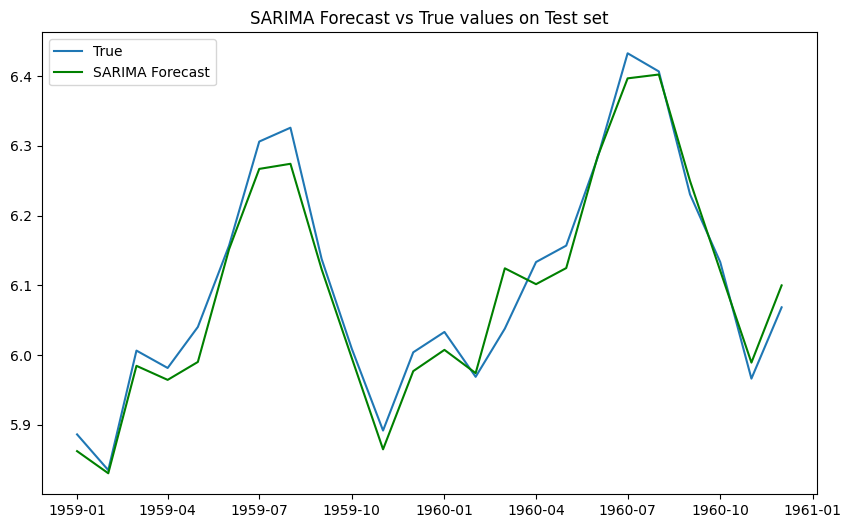

RSS: 0.02


In [335]:
sarima = SARIMAX(train, order=(p,1,q), seasonal_order=(P,0,Q,s))
results_SARIMA= sarima.fit()

fitted_values_SARIMA = results_SARIMA.fittedvalues.shift(-1)

forecast_SARIMA= results_SARIMA.forecast(steps=len(test))
forecast_SARIMA.index = test.index

plt.title("Fitted values on Train set")
plt.plot(train, label="True")
plt.plot(fitted_values_SARIMA, c="r", label="Fitted")
plt.legend()
plt.show()

plt.plot(test, label="True")
plt.plot(forecast_SARIMA, label="SARIMA Forecast", c="g")
plt.title("SARIMA Forecast vs True values on Test set")
plt.legend()
plt.show()

RSS_sarima = ((forecast_SARIMA - test["#Passengers"])**2).sum()
print(f"RSS: {RSS_sarima:.2f}")

### AutoARIMA
As we said previously, we firstly tried with the manual selection of p and q, but now we want to try to do it automatically, using the AUTOArima model.

Performing stepwise search to minimize aic


/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-193.784, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-195.846, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-197.533, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-194.869, Time=0.02 sec


/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-200.484, Time=0.12 sec


/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec


/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec


/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-197.689, Time=0.09 sec


/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-201.680, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-198.889, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-197.184, Time=0.06 sec


/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-208.368, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-198.771, Time=0.07 sec


/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-206.982, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-205.461, Time=0.19 sec


/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-206.861, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-197.523, Time=0.11 sec


/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-207.696, Time=0.23 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 3.404 seconds


/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


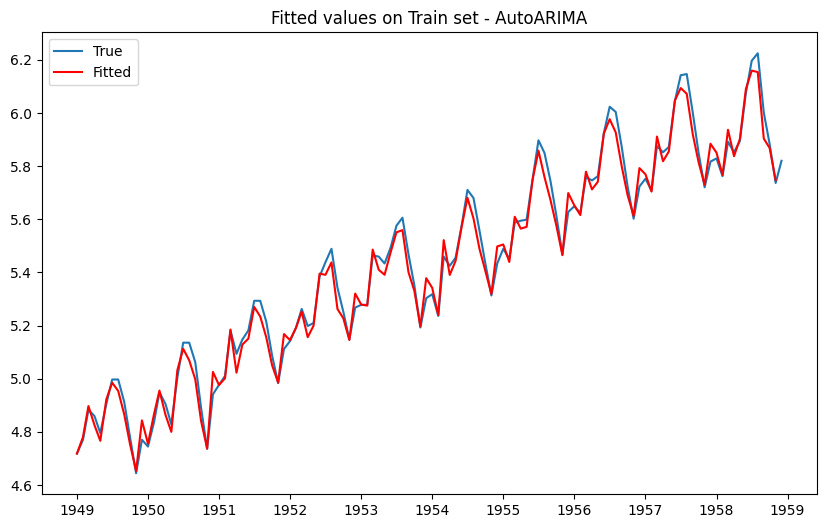

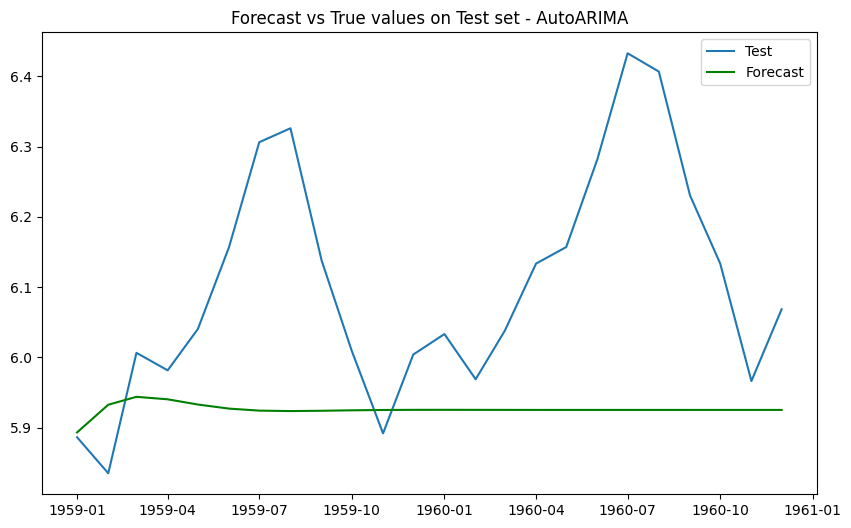

RSS: 1.35


In [336]:
from pmdarima.arima import AutoARIMA, auto_arima

autoArima = AutoARIMA(trace=True)
autoArima.fit(train)
autoArima.summary()

fitted_values_autoARIMA = autoArima.model_.fittedvalues().shift(-1)

forecast_autoARIMA = autoArima.predict(n_periods=len(test))
forecast_autoARIMA.index = test.index

plt.title("Fitted values on Train set - AutoARIMA")
plt.plot(train, label="True")
plt.plot(fitted_values_autoARIMA, c="r", label="Fitted")
plt.legend()
plt.show()

plt.title("Forecast vs True values on Test set - AutoARIMA")
plt.plot(test, label="Test")
plt.plot(forecast_autoARIMA, c="g", label="Forecast")
plt.legend()
plt.show()

RSS_autoARIMA = ((forecast_autoARIMA - test["#Passengers"])**2).sum()
print(f"RSS: {RSS_autoARIMA:.2f}")

As you can see, here the best model found has p=2, and q=1.

### Comparison Between Models
So we tried the AR,MA and ARIMA selecting manually the parameters, and the AutoARIMA, that selects automatically the parameters, and now we can make a comparison between them.

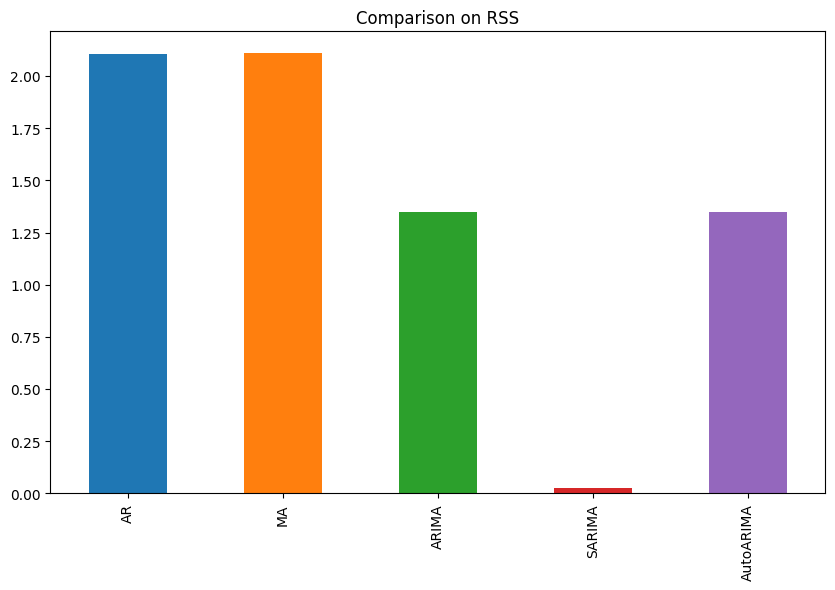

In [337]:
results_df = pd.DataFrame(columns=["AR", "MA", "ARIMA", "SARIMA", "AutoARIMA"])
results_df.loc['RSS'] = [RSS_ar, RSS_ma, RSS_arima, RSS_sarima, RSS_autoARIMA]

results_df.loc["RSS"].plot(kind="bar", color=sns.color_palette())
plt.title("Comparison on RSS")
plt.show()

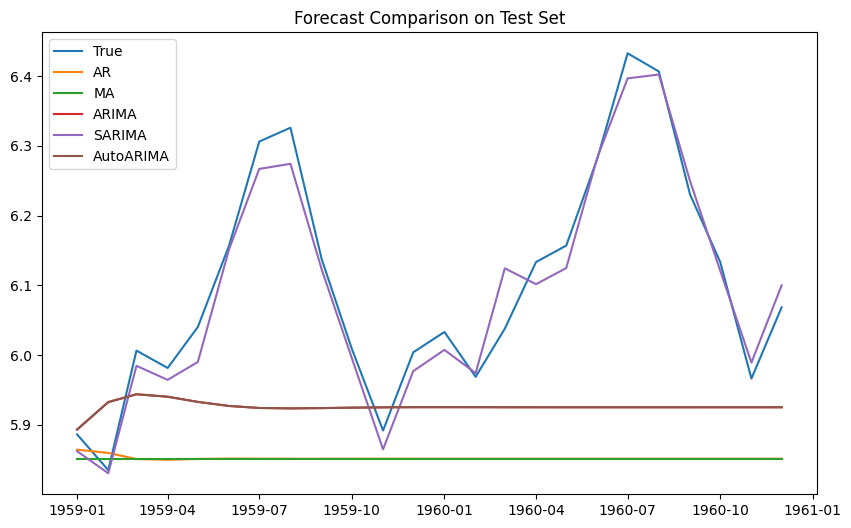

In [338]:
plt.plot(test, label="True")
plt.plot(forecast_AR, label="AR")
plt.plot(forecast_MA, label="MA")
plt.plot(forecast_ARIMA, label="ARIMA")
plt.plot(forecast_SARIMA, label="SARIMA")
plt.plot(forecast_autoARIMA, label="AutoARIMA")
plt.title("Forecast Comparison on Test Set")
plt.legend()
plt.show()

In [339]:
print(f"AR: {RSS_ar:.2f}")
print(f"MA: {RSS_ma:.2f}")
print(f"ARIMA: {RSS_arima:.2f}")
print(f"SARIMA: {RSS_sarima:.2f}")
print(f"AutoARIMA: {RSS_autoARIMA:.2f}")

AR: 2.11
MA: 2.11
ARIMA: 1.35
SARIMA: 0.02
AutoARIMA: 1.35


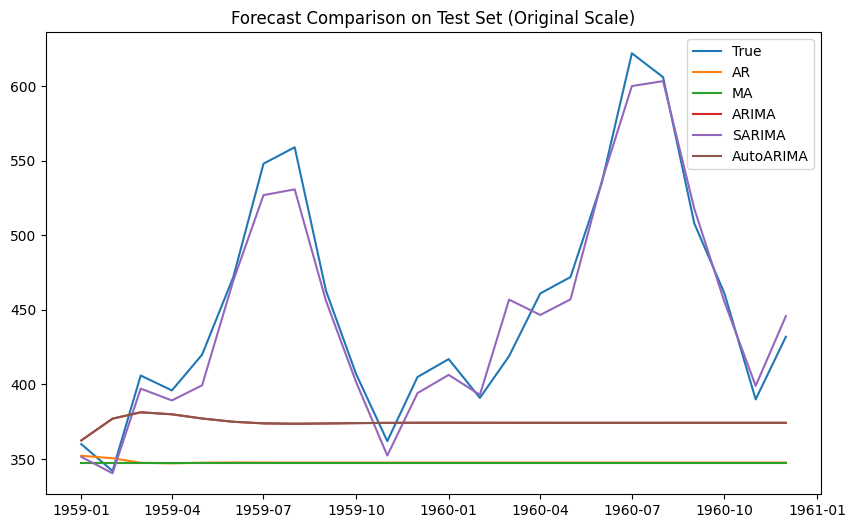

In [340]:
trues_exp = np.exp(test)
forecast_AR_exp = np.exp(forecast_AR)
forecast_MA_exp = np.exp(forecast_MA)
forecast_ARIMA_exp = np.exp(forecast_ARIMA)
forecast_SARIMA_exp = np.exp(forecast_SARIMA)
forecast_autoARIMA_exp = np.exp(forecast_autoARIMA)

plt.plot(trues_exp, label="True")
plt.plot(forecast_AR_exp, label="AR")
plt.plot(forecast_MA_exp, label="MA")
plt.plot(forecast_ARIMA_exp, label="ARIMA")
plt.plot(forecast_SARIMA_exp, label="SARIMA")
plt.plot(forecast_autoARIMA_exp, label="AutoARIMA")
plt.title("Forecast Comparison on Test Set (Original Scale)")
plt.legend()
plt.show()


AR: 396410.88
MA: 396484.72
ARIMA: 279132.51
SARIMA: 5027.60
AutoARIMA: 279132.51


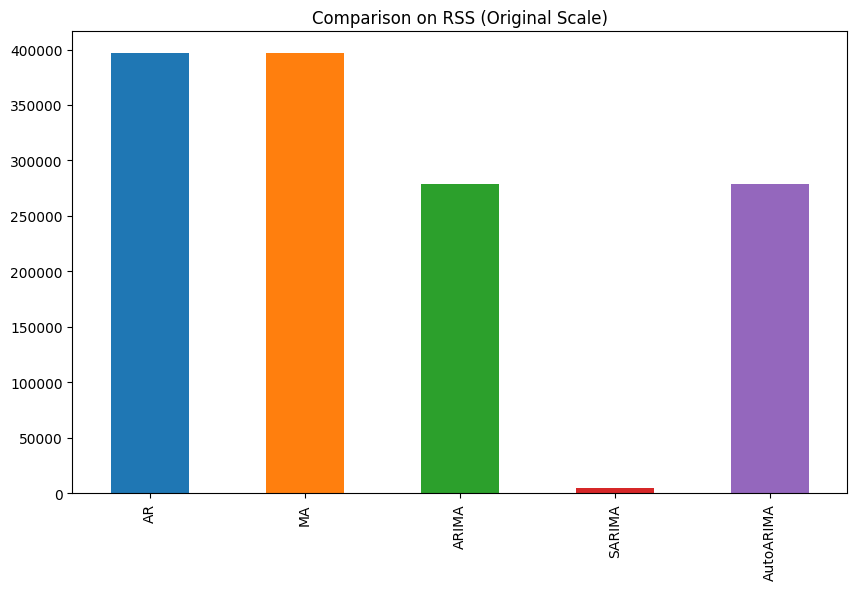

In [341]:
RSS_AR = ((forecast_AR_exp - trues_exp["#Passengers"])**2).sum()
print(f"AR: {RSS_AR:.2f}")

RSS_MA = ((forecast_MA_exp - trues_exp["#Passengers"])**2).sum()
print(f"MA: {RSS_MA:.2f}")

RSS_ARIMA = ((forecast_ARIMA_exp - trues_exp["#Passengers"])**2).sum()
print(f"ARIMA: {RSS_ARIMA:.2f}")

RSS_SARIMA = ((forecast_SARIMA_exp - trues_exp["#Passengers"])**2).sum()
print(f"SARIMA: {RSS_SARIMA:.2f}")

RSS_autoARIMA = ((forecast_autoARIMA_exp - trues_exp["#Passengers"])**2).sum()
print(f"AutoARIMA: {RSS_autoARIMA:.2f}")

results_df = pd.DataFrame(columns=["AR", "MA", "ARIMA", "SARIMA", "AutoARIMA"])
results_df.loc['RSS'] = [RSS_AR, RSS_MA, RSS_ARIMA, RSS_SARIMA, RSS_autoARIMA]
results_df.loc["RSS"].plot(kind="bar", color=sns.color_palette())
plt.title("Comparison on RSS (Original Scale)")
plt.show()


In [342]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

r2_AR = r2_score(test, forecast_AR)
r2_MA = r2_score(test, forecast_MA)
r2_ARIMA = r2_score(test, forecast_ARIMA)
r2_SARIMA = r2_score(test, forecast_SARIMA)
r2_autoARIMA = r2_score(test, forecast_autoARIMA)

RMSE_AR = root_mean_squared_error(test, forecast_AR)
RMSE_MA = root_mean_squared_error(test, forecast_MA)
RMSE_ARIMA = root_mean_squared_error(test, forecast_ARIMA)
RMSE_SARIMA = root_mean_squared_error(test, forecast_SARIMA)
RMSE_autoARIMA = root_mean_squared_error(test, forecast_autoARIMA)

MAE_AR = mean_absolute_error(test, forecast_AR)
MAE_MA = mean_absolute_error(test, forecast_MA)
MAE_ARIMA = mean_absolute_error(test, forecast_ARIMA)
MAE_SARIMA = mean_absolute_error(test, forecast_SARIMA)
MAE_autoARIMA = mean_absolute_error(test, forecast_autoARIMA)

metrics = pd.DataFrame({
    "Model": ["AR", "MA", "ARIMA", "SARIMA"],
    "RSS": [RSS_AR, RSS_MA, RSS_ARIMA, RSS_SARIMA],
    "MAE": [MAE_AR, MAE_MA, MAE_ARIMA, MAE_SARIMA],
    "RMSE": [RMSE_AR, RMSE_MA, RMSE_ARIMA, RMSE_SARIMA],
    # "R²": [r2_AR, r2_MA, r2_ARIMA, r2_SARIMA]
})
metrics.set_index("Model", inplace=True)

metrics.sort_values("RMSE", inplace=True)
metrics

,RSS,MAE,RMSE
Model,,,
SARIMA,5027.598912,0.025238,0.031341
ARIMA,279132.505787,0.187138,0.237033
AR,396410.882837,0.251335,0.296370
MA,396484.722775,0.251490,0.296404


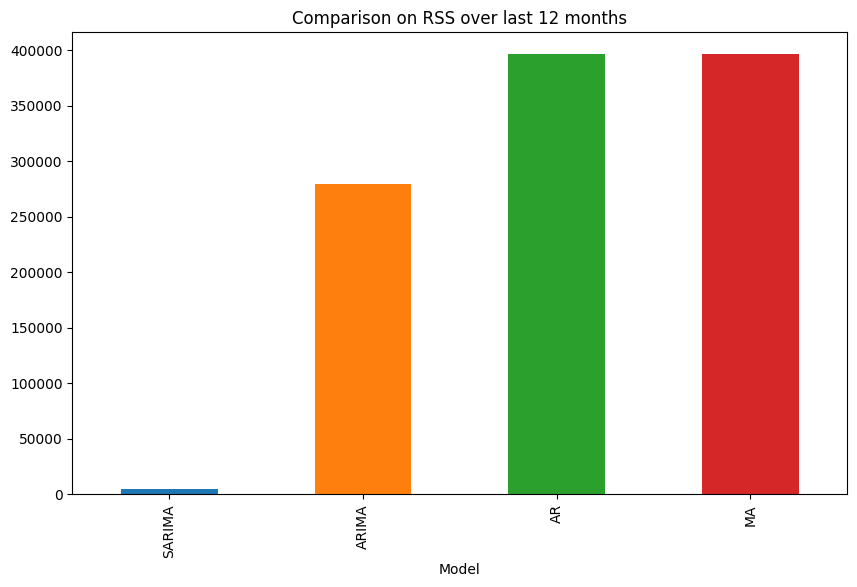

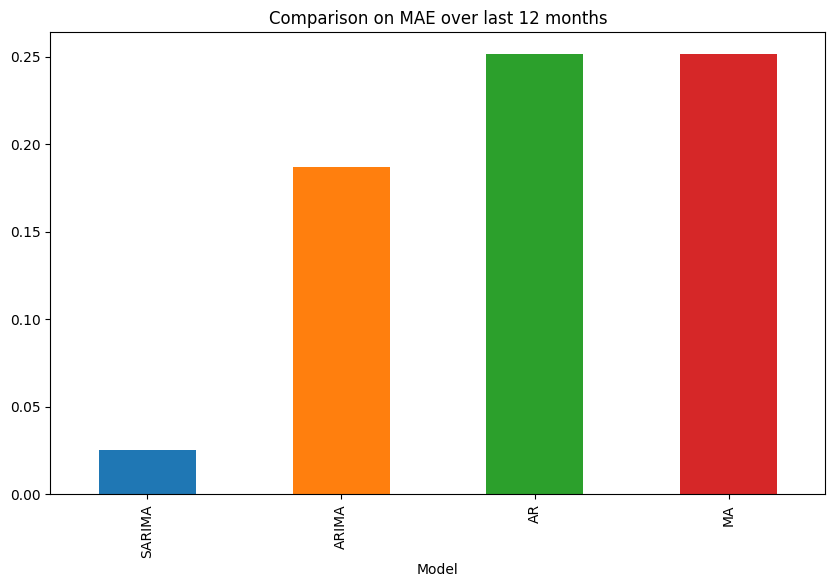

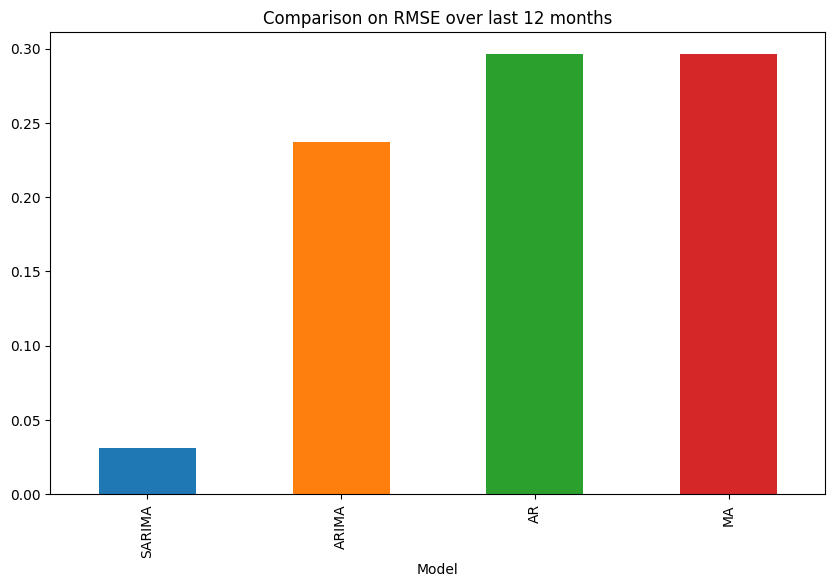

In [343]:
for entry in metrics.sort_values("RMSE", ascending=False):
    metrics[entry].plot(kind="bar", color=sns.color_palette())
    plt.title(f"Comparison on {entry} over last 12 months")
    plt.show()

## Conclusion

As a conclusion we can see that even all the ARIMA models, doesn't work very well, because they can't catch the seasonal component, and they predict values around the mean of the series, and that's not so good. While with Seasonal ARIMA (SARIMA) we manage to catch the seasonality and to make a closer prediction to the true values, so it seems that it is the best and only one that can be considered valide.

For the other models we can say that maybe they are not very suitable to this dataset.